In [1]:
import os
import numpy as np
import math 

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio

import matplotlib.pyplot as plt
from pydub import AudioSegment
import librosa
from sklearn.preprocessing import minmax_scale
import emd
import time

In [2]:
# TODO: modify below path when needed
RAW_DATASET_PATH = os.path.join("..", "animal_sounds")
DATASET_AUDIO_PATH = os.path.join("..", "animal_sounds_clips")
# The sampling rate to use.
# This is the one used in all of the audio samples.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000
# percentage of recordings used for validation
TEST_RATIO = 0.05
CLIP_LEN = 500

In [3]:
def prepare_data():
    if not os.path.exists(DATASET_AUDIO_PATH):
        os.makedirs(DATASET_AUDIO_PATH)

    for class_name in os.listdir(RAW_DATASET_PATH):
        before = 0
        after = 0
        files = os.listdir(os.path.join(RAW_DATASET_PATH, class_name))
        for file in files:
            if before < TEST_RATIO * len(files):
                target_path = os.path.join(DATASET_AUDIO_PATH, class_name[:-2]+"_valid")
            else:
                target_path = os.path.join(DATASET_AUDIO_PATH, class_name[:-2])
            if not os.path.exists(target_path):
                os.makedirs(target_path)
            p = os.path.join(RAW_DATASET_PATH, class_name, file)
            try:
                audio = AudioSegment.from_wav(p)
                audio = audio.set_frame_rate(SAMPLING_RATE)
            except:
                print(f"Could not load file {p}. Skipping.")
                continue
            before += 1
            step = math.floor(CLIP_LEN / 2.5) if class_name.startswith("kidney") or class_name.startswith("muscle") else CLIP_LEN // 2
            for t in range(3000, len(audio)-CLIP_LEN, step):
                after += 1
                new_audio = audio[t:t+CLIP_LEN]
                split = os.path.splitext(file)
                filename = split[0] + f"_{after}_{class_name}" + split[1]
                new_audio.export(os.path.join(target_path, filename),
                                format="wav", parameters=["-sample_fmt", "s16"])
        print(f"{class_name}: Split {before} tracks into {after} clips of length {CLIP_LEN/1000}s")

prepare_data() # this needs to be run just once

animal_ribs_1: Split 53 tracks into 78 clips of length 0.5s
Could not load file ..\animal_sounds\kidney_animal_1\REC67.WAV. Skipping.
kidney_animal_1: Split 45 tracks into 149 clips of length 0.5s
kidney_animal_2: Split 51 tracks into 276 clips of length 0.5s
liver_animal 2: Split 57 tracks into 629 clips of length 0.5s
Could not load file ..\animal_sounds\liver_animal_1\REC103.WAV. Skipping.
Could not load file ..\animal_sounds\liver_animal_1\REC107.WAV. Skipping.
liver_animal_1: Split 42 tracks into 268 clips of length 0.5s
Could not load file ..\animal_sounds\muscle_animal_1\REC77.WAV. Skipping.
muscle_animal_1: Split 46 tracks into 122 clips of length 0.5s
muscle_animal_2: Split 59 tracks into 268 clips of length 0.5s
Could not load file ..\animal_sounds\ribs_animal_2\REC83.WAV. Skipping.
Could not load file ..\animal_sounds\ribs_animal_2\REC85.WAV. Skipping.
Could not load file ..\animal_sounds\ribs_animal_2\REC89.WAV. Skipping.
Could not load file ..\animal_sounds\ribs_animal_2\R

In [118]:
def paths_and_labels_to_dataset(audio_paths, labels, preprocessing_func):
    """Constructs a dataset of audios and labels."""
    audios = [path_to_audio(path) for path in audio_paths]
    audios = [preprocessing_func(audio) for audio in audios]
    audio_ds = tf.data.Dataset.from_tensor_slices(audios)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio.numpy()

# TODO
# def normalize(x, axis=0):
#     return minmax_scale(x, axis=axis)

def join(array_1, array_2):
    return np.concatenate((array_1, array_2))

def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

# TODO: below functions can be used as replacement/addition to audio_to_fft. Call them in analogous way
def audio_to_mfccs(audio):
    audio = audio.reshape(audio.shape[0],)
    mfccs = librosa.feature.mfcc(y=audio, sr=SAMPLING_RATE, n_fft=len(audio) // 2).flatten()
    mfccs = mfccs.reshape(1, mfccs.shape[0])
    return mfccs

def audio_to_centroids(audio):
    audio = audio.reshape(audio.shape[0],)
    audio_length = len(audio)
    centroids = librosa.feature.spectral_centroid(y=audio, sr=SAMPLING_RATE, n_fft=audio_length, hop_length=audio_length // 64)[0]
    centroids = centroids.reshape(1, centroids.shape[0])
    return centroids
    # return normalize(centroids) # normalization does not make sense at interval
    
def audio_to_imfs(audio, to_take=8):
    imfs = emd.sift.sift(audio)
    return imfs[:, :to_take]

def preprocessing_pure(audio):
    return audio

def preprocessing_only_imfs(audio):
    return audio_to_imfs(audio)

def preprocessing_imfs_with_hilbert_huang(audio):
    imfs = audio_to_imfs(audio)
    IP, IF, IA = emd.spectra.frequency_transform(imfs, SAMPLING_RATE, 'hilbert')
    return join(join(imfs, IP), join(IF, IA))

def preprocessing_only_mfccs(audio):
    return audio_to_mfccs(audio)

def preprocessing_only_centroids(audio):
    return audio_to_centroids(audio)

In [140]:
SHUFFLE_SEED = 5123
BATCH_SIZE = 128
EPOCHS = 100 # TODO
PREPROCESSING_FUNC = preprocessing_only_centroids
TO_TAKE_COUNT = 1_000_000

In [135]:
# path = train_audio_paths[9]
# audio = path_to_audio(path)
# print(f"audio shape : {audio.shape}, audio min : {np.min(audio)}, audio max : {np.max(audio)}")

# centroid = audio_to_centroids(audio)
# print(f"centroid shape : {centroid.shape}, centroid min : {np.min(centroid)}, centroid max : {np.max(centroid)}")

# # mfccs = audio_to_mfccs(audio)
# # print(f"mfccs shape : {mfccs.shape}, mfccs min : {np.min(mfccs)}, mfccs max : {np.max(mfccs)}")
# plt.plot(centroid[0,:-1])
# plt.show()

In [136]:
# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

train_audio_paths = []
valid_audio_paths = []
train_labels = []
valid_labels = []
for label, name in enumerate(class_names):
    # print("Processing material {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.lower().endswith(".wav")
    ]
    label = label // 2 # coz every dir has a _valid copy
    if name.endswith("_valid"):
        valid_audio_paths += speaker_sample_paths
        valid_labels += [label] * len(speaker_sample_paths)
    else:
        train_audio_paths += speaker_sample_paths
        train_labels += [label] * len(speaker_sample_paths)
    # print(f"Loaded {len(speaker_sample_paths)} files from class {label}.")
    
print(
    "Found {} files belonging to {} classes.".format(len(train_audio_paths) + len(valid_audio_paths), len(class_names)//2)
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(valid_audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_labels)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(valid_labels)

print("Using {} files for training.".format(len(train_labels)))
print("Using {} files for validation.".format(len(valid_labels)))

# Create 2 datasets, one for training and the other for validation

start = time.time()
train_audio_paths = train_audio_paths[:TO_TAKE_COUNT]
valid_audio_paths = valid_audio_paths[:TO_TAKE_COUNT]
train_labels = train_labels[:TO_TAKE_COUNT]
valid_labels = valid_labels[:TO_TAKE_COUNT]

train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels, PREPROCESSING_FUNC)
# train_ds = train_ds.map(lambda x, y: (tf.reshape(x, (1, x.shape[0])), y))
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)


end = time.time()
elapsed = end - start

print(f"finished preparing training dataset : {elapsed:.2f}")

start = time.time()

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels, PREPROCESSING_FUNC)
# valid_ds = valid_ds.map(lambda x, y: (tf.reshape(x, (1, x.shape[0])), y))
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

# end = time.time()
# elapsed = end - start

# print(f"finished preparing validation dataset : {elapsed:.2f}")

# # Transform audio wave to the frequency domain using `audio_to_fft`
# # train_ds = train_ds.map(
# #     lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
# # )
# train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# # valid_ds = valid_ds.map(
# #     lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
# # )
# valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)


Our class names: ['animal_ribs', 'animal_ribs_valid', 'kidney_animal', 'kidney_animal_valid', 'liver_animal', 'liver_animal_valid', 'muscle_animal', 'muscle_animal_valid', 'ribs_animal', 'ribs_animal_valid', 'skin_animal', 'skin_animal_valid']
Found 3048 files belonging to 6 classes.
Using 2939 files for training.
Using 109 files for validation.
finished preparing training dataset : 112.47


In [143]:
INPUT_SHAPE = list(train_ds.take(1))[0][0].shape[1:]
valid_shape = list(valid_ds.take(1))[0][0].shape[1:] # just to check everything is ok
assert INPUT_SHAPE == valid_shape
print(INPUT_SHAPE)

(1, 65)


In [138]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    s = keras.layers.Conv1D(filters, 3, padding="same")(x)
    for _ in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=1, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=1, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

model = build_model(INPUT_SHAPE, len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "my_best_model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1, 65)]      0           []                               
                                                                                                  
 conv1d_127 (Conv1D)            (None, 1, 16)        3136        ['input[0][0]']                  
                                                                                                  
 activation_90 (Activation)     (None, 1, 16)        0           ['conv1d_127[0][0]']             
                                                                                                  
 conv1d_128 (Conv1D)            (None, 1, 16)        784         ['activation_90[0][0]']          
                                                                                            

In [141]:
# CHECKPOINT_PATH = Path("my_best_model.h5")
# history = None
# if os.path.exists(CHECKPOINT_PATH):
#     model.load_weights(CHECKPOINT_PATH)
# else:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/100
 1/23 [>.............................] - ETA: 0s - loss: 1.7073 - accuracy: 0.3906

23/23 [==============================] - 0s 14ms/step - loss: 1.6057 - accuracy: 0.3168 - val_loss: 1.7866 - val_accuracy: 0.3761
Epoch 2/100
23/23 [==============================] - 0s 9ms/step - loss: 1.5410 - accuracy: 0.3396 - val_loss: 1.7853 - val_accuracy: 0.2661
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 1.5236 - accuracy: 0.3447 - val_loss: 1.6810 - val_accuracy: 0.3394
Epoch 4/100
23/23 [==============================] - 0s 9ms/step - loss: 1.5418 - accuracy: 0.3399 - val_loss: 1.6171 - val_accuracy: 0.2844
Epoch 5/100
23/23 [==============================] - 0s 8ms/step - loss: 1.5263 - accuracy: 0.3351 - val_loss: 1.7780 - val_accuracy: 0.1468
Epoch 6/100
23/23 [==============================] - 0s 8ms/step - loss: 1.5530 - accuracy: 0.3246 - val_loss: 1.7352 - val_accuracy: 0.2752
Epoch 7/100
23/23 [==============================] - 0s 9ms/step - loss: 1.5343 - accuracy: 0.3304 - val_loss: 1.6956 - val_accuracy: 0.2661
Epoch 8/100
23/23 [=====

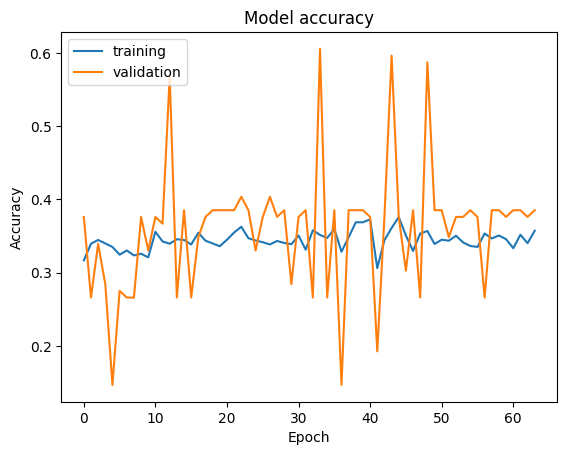

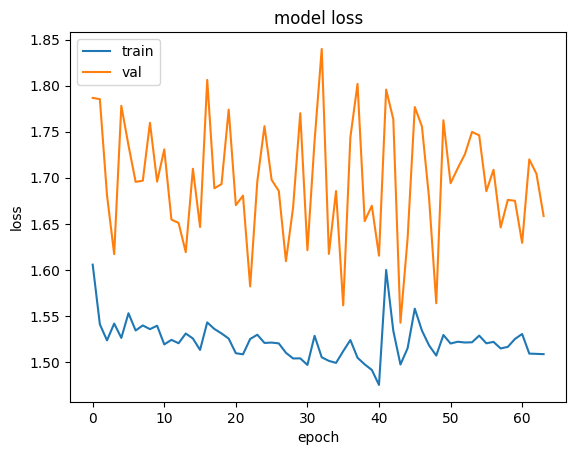

In [142]:
if history is not None:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
test_ds = paths_and_labels_to_dataset(train_audio_paths + valid_audio_paths, train_labels + valid_labels, PREPROCESSING_FUNC)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

actual_class_names = [n for n in class_names if not n.endswith("_valid")]

confusion = np.zeros((len(actual_class_names),)*2, dtype=np.float32)
counter = 0
for audios, labels in test_ds.take(1000):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    y_pred = np.argmax(y_pred, axis=-1)
    for idx, pred in enumerate(y_pred):
        counter += 1
        confusion[labels[idx], pred] += 1

print(counter)


for idx, label in enumerate(actual_class_names):
    confusion[idx, :] /= np.sum(confusion[idx, :])
    print(f"{idx} - {label}")

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
labels = [x.split("_")[0] for x in actual_class_names]
# labels = ["ribs", "kidney", "liver", "muscle", "skin"]
df_cm = pd.DataFrame(confusion, index=labels, columns=labels)
plt.figure(figsize=(7, 5))
sn.heatmap(df_cm, annot=True, fmt=".3f", square=True, cbar=False, cmap="Blues", linewidths=3, vmin=0, vmax=1)
plt.xlabel("Predicted label", labelpad=16)
plt.ylabel("True label", labelpad=12)
plt.tick_params(axis='y', rotation=0)
plt.show()